In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [16]:
train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/SkinAndEye/augmentedImages/train'
validation_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/SkinAndEye/augmentedImages/test'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/SkinAndEye/augmentedImages/test'

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 2592 images belonging to 2 classes.


In [19]:
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 441 images belonging to 2 classes.


In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 441 images belonging to 2 classes.


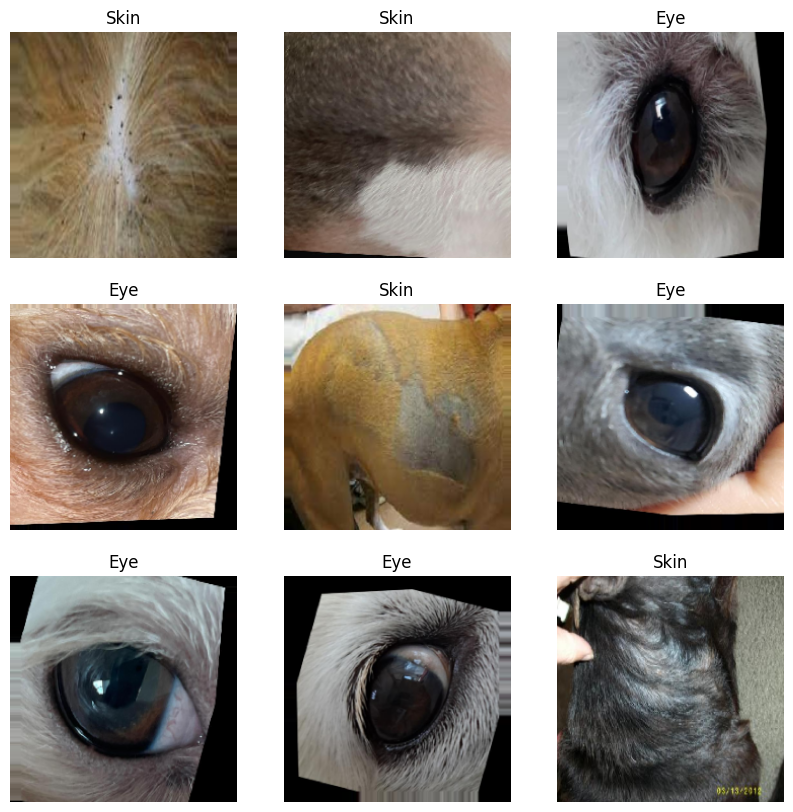

In [21]:
batch = train_generator.next()
images, labels = batch[0], batch[1]

label_names = ['Eye','Skin',]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    
    label_index = np.argmax(labels[i])
    label = label_names[label_index]
    
    plt.title(label)
    plt.axis("off")
plt.show()


In [22]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [24]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
81/81 [==============================] - 28s 336ms/step - loss: 0.1350 - accuracy: 0.9514 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 2/20
81/81 [==============================] - 27s 331ms/step - loss: 0.0278 - accuracy: 0.9919 - val_loss: 0.0235 - val_accuracy: 0.9909
Epoch 3/20
81/81 [==============================] - 27s 337ms/step - loss: 0.0313 - accuracy: 0.9915 - val_loss: 0.0445 - val_accuracy: 0.9864
Epoch 4/20
81/81 [==============================] - 29s 362ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0146 - val_accuracy: 0.9955
Epoch 5/20
81/81 [==============================] - 30s 370ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0134 - val_accuracy: 0.9955
Epoch 6/20
81/81 [==============================] - 30s 369ms/step - loss: 0.0204 - accuracy: 0.9907 - val_loss: 0.0179 - val_accuracy: 0.9909
Epoch 7/20
81/81 [==============================] - 31s 383ms/step - loss: 0.0156 - accuracy: 0.9927 - val_loss: 0.0150 - val_accuracy: 0.9932

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

14/14 [==============================] - 4s 268ms/step - loss: 0.0087 - accuracy: 0.9977
Test Accuracy: 0.997732400894165


In [26]:
model.save('MobileNetV2_multi_Skin.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


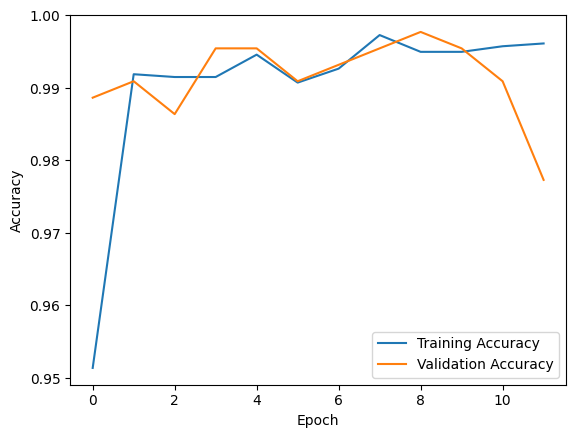

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

14/14 [==============================] - 5s 283ms/step
Classification Report:
              precision    recall  f1-score   support

         eye       1.00      1.00      1.00       254
        skin       1.00      0.99      1.00       187

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



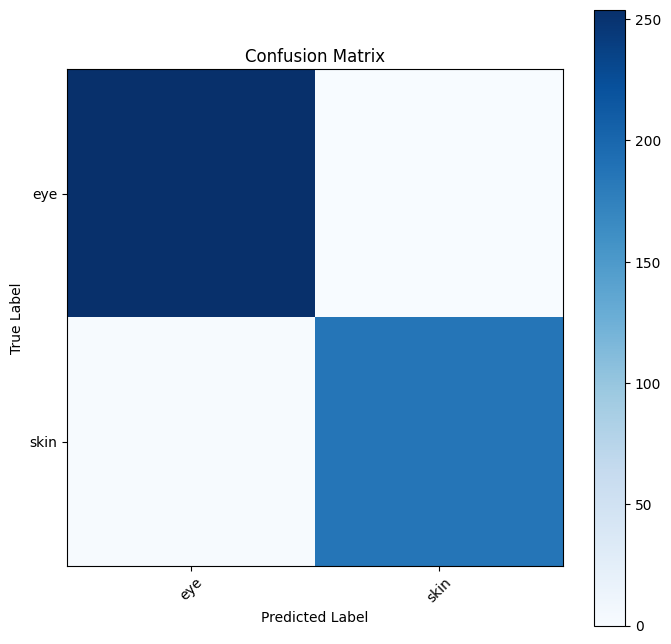

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
